In [1]:
from netCDF4 import Dataset
from netCDFfunc.utility import get_data_sequence, get_data_A, get_data_by_date, save_img, show_img, masking, test_data_write

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
base_dir = '/Volumes/T7/AVHRR_OI_SST/v2.1/'

mask_list = get_data_sequence(base_dir = base_dir,
                          get_data_func = get_data_A,
                          var_name = 'ice',
                          start_date = (1981,9,1),
                          end_date = (2021,12,31),
                          is_mask=True)

mask_arr = np.full(mask_list[0].shape, False)
for mask in mask_list :
    mask_arr = np.ma.array(mask_arr, mask = np.invert(mask))
    mask_arr = mask_arr.filled(fill_value = True)

ds_new.close()

base_dir = '/Volumes/T7/new_data/utility_data/'
file_name = 'accumulated_ice_mask'

nc_path = os.path.join(base_dir,file_name+'.nc')
#img_path = os.path.join(base_dir, 'img' ,file_name+'.jpg')

ds_new = Dataset(nc_path, 'w', format='NETCDF4')
title = '40 years(1981~2021) ice mask data'
comment = 'accumulated mask of ice mask for 40 years'

grid_size = 0.25


data = mask_arr

variable_name = 'ice'
variable_standard_name = 'accumulated ice mask'
variable_unit = ''
variable_dtype = np.intc
variable_values = data

ds_new = test_data_write(ds_new, title, comment, grid_size,
                         variable_name, 
                         variable_standard_name, 
                         variable_unit, 
                         variable_dtype, 
                         variable_values)

#save_img(ds_new.variables['avgsst'][:].data[0], img_path)

ds_new.close()

In [3]:
ice_mask = Dataset('/Volumes/T7/new_data/utility_data/accumulated_ice_mask.nc', 'r', format='NETCDF4')
ice = ice_mask.variables['ice'][:].data[0]

for year in range(1982, 2021):
    value = get_data_sequence(base_dir = base_dir,
                              get_data_func = get_data_A,
                              var_name = 'sst',
                              start_date = (year,1,1),
                              end_date = (year,12,31))
    
    masked_value = masking(value, ice)
    distribution = masked_value.flatten()
    np.place(distribution, distribution == -999, np.nan)
    min_value = np.nanmin(distribution)
    max_value = np.nanmax(distribution)
    plt.hist(distribution, bins=100)
    plt.savefig(f'/Volumes/T7/intermediate output/ice_masked_distribution/{year}_min=({min_value:.2f})&max=({max_value:.2f}).jpg', dpi=100)
    plt.close()

In [4]:
ds_average = Dataset('/Volumes/T7/new_data/processed_data_example/nc/1_30_years_dataset_1_global.nc', 'r', format='NETCDF4')
avg = ds_average.variables['avgsst'][:].data[0]

In [5]:
ds_pctl = Dataset('/Volumes/T7/new_data/processed_data_example/nc/7_30_years_dataset_1_90_percentile.nc', 'r', format='NETCDF4')
pctl = ds_pctl.variables['90pctlSST'][:].data[0]

In [6]:
ds_std = Dataset('/Volumes/T7/new_data/processed_data_example/nc/19_30_years_dataset_1_global_std.nc', 'r', format='NETCDF4')
std = ds_std.variables['std'][:].data[0]

In [7]:
ds_sst = get_data_by_date(base_dir=base_dir,
                          get_data_func=get_data_A,
                          var_name='sst',
                          start_date=(2020,1,1),
                          end_date=(2021,12,31),
                          specific_year=2021,
                          specific_date=(1,1))

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
sst = ds_sst[(1,1)][0]

In [9]:
pctl

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [-1.4039999, -1.4039999, -1.4039999, ..., -1.4129999, -1.4039999,
        -1.4039999],
       [-1.4129999, -1.4129999, -1.4129999, ..., -1.4129999, -1.4129999,
        -1.4129999],
       [-1.4219999, -1.4219999, -1.4219999, ..., -1.4219999, -1.4219999,
        -1.4219999]], dtype=float32)

In [10]:
anormally = (sst - pctl)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
lat = ds_std.variables['lat'][:].data
lon = ds_std.variables['lon'][:].data

In [13]:
def show_img(arr, lat, lon):
    fig, ax = plt.subplots(figsize=(24,12))
    gca_ax = plt.gca()
    
    if arr.dtype == np.float32:
        np.place(arr, arr[:,:]==-999, np.nan)
    
    cmap = cm.jet.copy()
    cmap.set_bad(color='gray')
    im = plt.imshow(arr, cmap=cmap, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()])
    
    plt.xticks(range(0,361, 20))
    plt.yticks(range(-80,81,20))
    plt.grid(True, linestyle='--', color='black')
    
    x_labels = ['20°E','40°E','60°E','80°E','100°E','120°E','140°E','160°E','180°','160°W','140°W','120°W','100°W','80°W','60°W','40°W','20°W','0','20°E']
    y_labels = ['80°S','60°S','40°S','20°S','0°','20°N','40°N','60°N','80°N']
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    
    
    divider = make_axes_locatable(gca_ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    plt.colorbar(im, cax=cax)
    
    plt.show()
    plt.close()

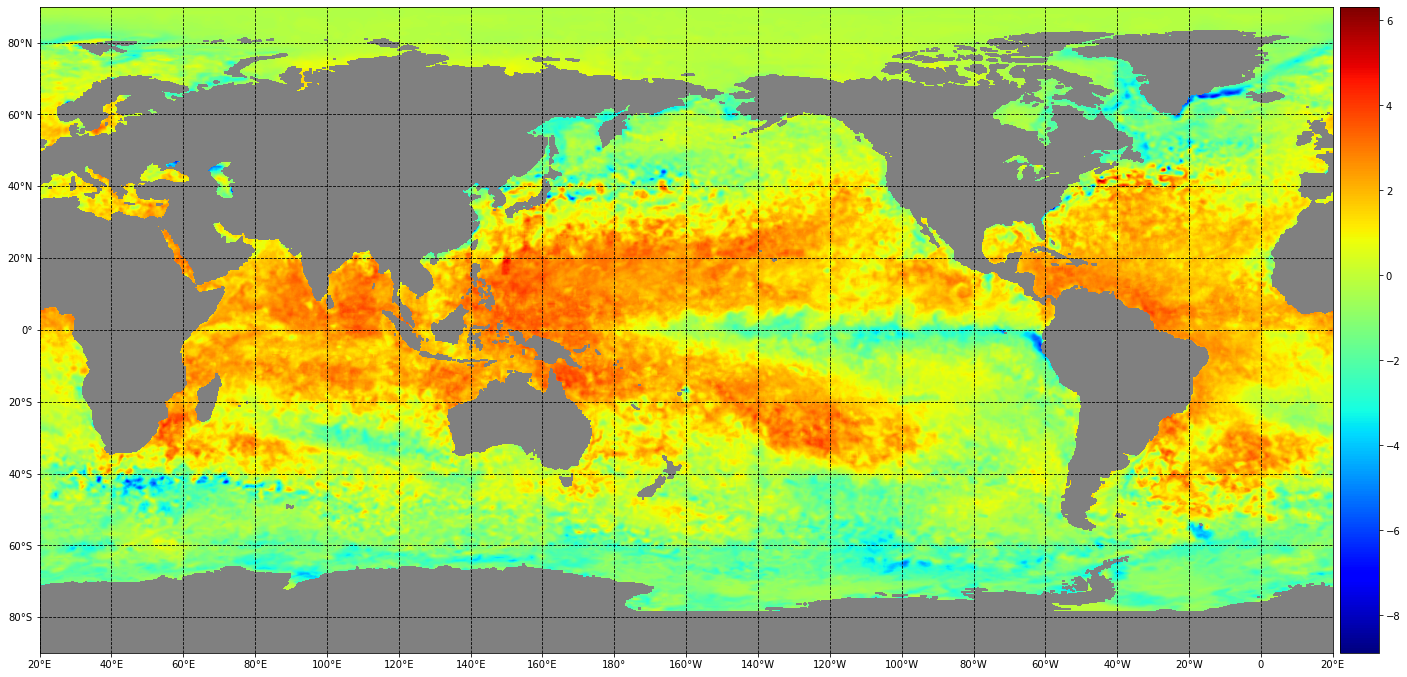

In [14]:
show_img(anormally, lat, lon)

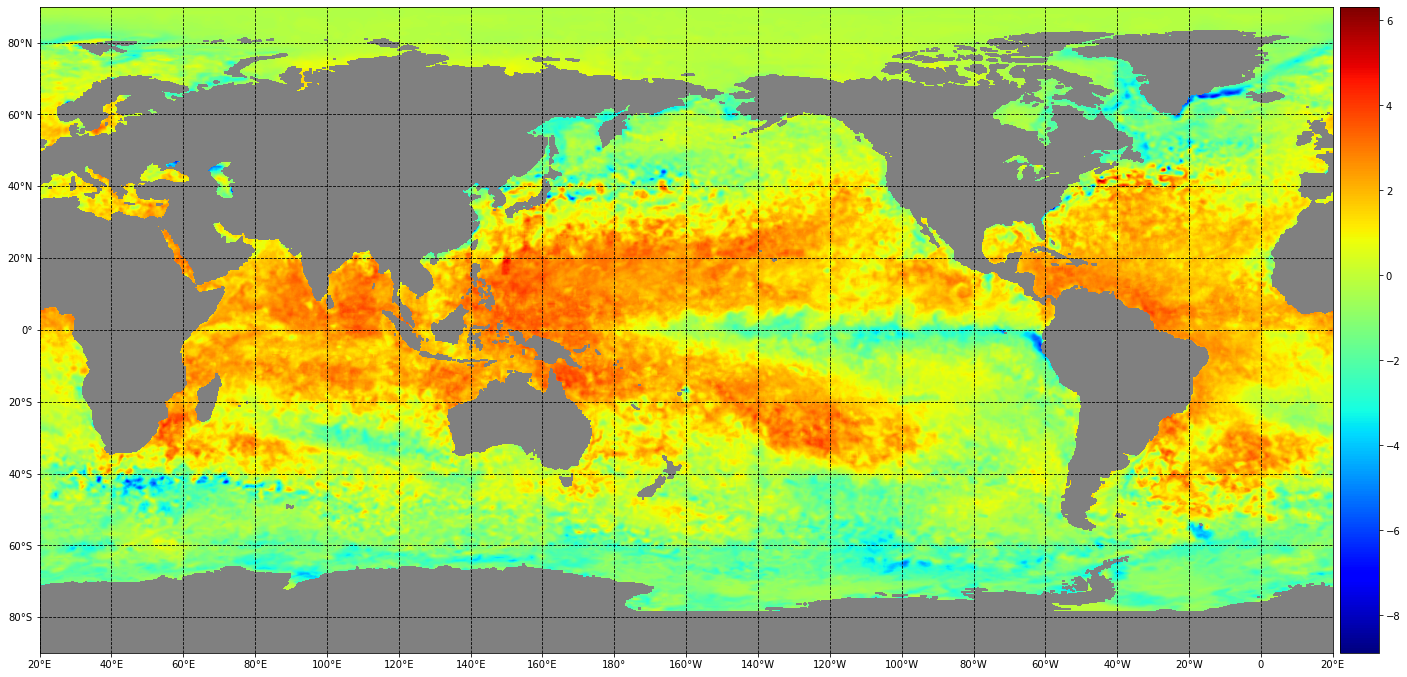

In [15]:
save_img(anormally, output_path='/Volumes/T7/new_data/processed_data_example/img/2_0_anormally_sample_2.jpg', lat=lat, lon=lon)